# Réseau CNN+LSTM pour le MNIST avec Keras

On import d'abord ce qu'il faut.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Flatten, Reshape

from keras.datasets import mnist

Using TensorFlow backend.


On importe les données du MNSIT et on les met en forme pour Keras.

In [2]:
# Load training and eval data
num_classes = 10
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
output_sequence_lenght = 4
num_classes = 11

temp_y_train = np.zeros((y_train.shape[0], output_sequence_lenght, num_classes))
temp_y_train[:, :-1, 0] = 1
temp_y_train[:, -1, 1:] = y_train
y_train = temp_y_train

temp_y_test = np.zeros((y_test.shape[0], output_sequence_lenght, num_classes))
temp_y_test[:, :-1, 0] = 1
temp_y_test[:, -1, 1:] = y_test
y_test = temp_y_test

In [6]:
y_train[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

On crée un modèle.

Le modèle est séquentiel : une couche après l'autre.
On ajoute les couches dans l'ordre.

In [7]:
model = Sequential()

# cnn
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (7, 4), padding='valid', activation='relu'))
model.add(Dropout(0.25))

# lstm
model.add(Reshape((output_sequence_lenght, 64)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))

# dense
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 4, 64)          114752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4, 64)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 64)             0         
__________

Le modèle doit être compilé avant d'être entrainé et utilisé.

In [8]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

On entraîne le réseau.

In [9]:
batch_size = 250
epochs = 20

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 170us/step - loss: 0.7371 - acc: 0.7811 - val_loss: 0.4623 - val_acc: 0.8431
Epoch 2/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.4077 - acc: 0.8477 - val_loss: 0.2531 - val_acc: 0.9144
Epoch 3/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.2562 - acc: 0.9106 - val_loss: 0.1102 - val_acc: 0.9725
Epoch 4/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.1359 - acc: 0.9602 - val_loss: 0.0466 - val_acc: 0.9878
Epoch 5/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.0789 - acc: 0.9800 - val_loss: 0.0298 - val_acc: 0.9919
Epoch 6/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.0557 - acc: 0.9866 - val_loss: 0.0220 - val_acc: 0.9935
Epoch 7/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.0430 - acc: 0.9897 - val_loss: 0.0172 - val_a

KeyboardInterrupt: 

On évalue le réseau.

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

In [12]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.009740392529947349
Test accuracy: 0.9977


Pour 1 LSTM :

- Test loss: 0.026182870787246064
- Test accuracy: 0.9921

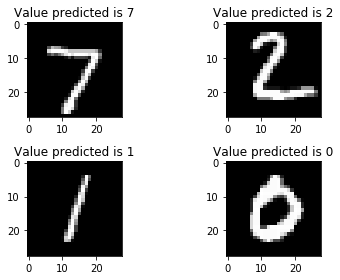

In [26]:
for i in range(4):
    predicted = model.predict(np.array([x_test[i]]), batch_size=1).argmax(axis=2)[0,-1]-1
    plt.subplot(2, 2, i+1)
    plt.title("Value predicted is {}".format(predicted))
    plt.imshow(x_test[i].reshape(img_rows, img_cols), cmap='gray')
plt.tight_layout()

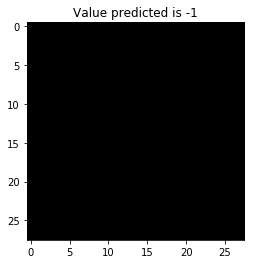

In [63]:
predicted = model.predict(np.array([np.zeros((28,28,1))]), batch_size=1).argmax(axis=2)[0,-1]-1
plt.title("Value predicted is {}".format(predicted))
plt.imshow(np.zeros((28,28)).reshape(img_rows, img_cols), cmap='gray')

In [42]:
y_test_class = y_test.argmax(axis=2)[:,-1]-1
y_predicted_class = model.predict(x_test).argmax(axis=2)[:,-1]-1

In [44]:
confusion_matrix = np.zeros((10, 10))

In [45]:
for i in range(10):
    for j in range(10):
        confusion_matrix[i,j] += np.sum(np.logical_and(y_test_class == i, y_predicted_class == j))

In [46]:
confusion_matrix.astype(int)

array([[ 978,    0,    0,    0,    0,    0,    2,    0,    0,    0],
       [   0, 1128,    2,    1,    0,    1,    1,    1,    1,    0],
       [   2,    0, 1027,    0,    1,    0,    0,    1,    1,    0],
       [   0,    0,    1, 1006,    0,    2,    0,    0,    1,    0],
       [   0,    0,    0,    0,  976,    0,    4,    0,    0,    2],
       [   2,    0,    0,    5,    0,  884,    1,    0,    0,    0],
       [   3,    2,    2,    0,    1,    1,  949,    0,    0,    0],
       [   0,    5,    7,    3,    0,    0,    0, 1010,    1,    2],
       [   2,    0,    2,    1,    0,    0,    1,    0,  968,    0],
       [   2,    0,    0,    4,    7,    4,    0,    3,    7,  982]])

/home/arsleust/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,0,'TRUE')

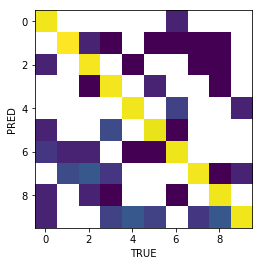

In [64]:
plt.imshow(np.log(confusion_matrix))
plt.ylabel("PRED")
plt.xlabel("TRUE")